# TIGRFAM functional analysis of synthetic metagenomes
*Authors:* Fredrik Boulund, Luisa Hugerth

*Date*: December 2017

This notebook summarizes the TIGRFAM-based functional analysis of several synthetic metagenomes, in an attempt to estimate a suitable sequencing depth for several different sample types commonly encountered at The Centre for Translational Microbiome Research (CTMR). 



In [1]:
from glob import glob
from os import path, mkdir

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("white")

In [2]:
outdir = "tigrfam_reads"
try:
    mkdir(outdir)
except OSError:
    pass

## Define utility functions
The following cell defines some utility functions.

In [3]:
def load_TIGRFAM_counts(counts_filename):
    """
    Load TIGRFAM counts from two-column tables produced by count_tigrfam_annotations.py
    """
    sample_name = path.basename(counts_filename).split(".")[0]
    tigrfam_counts = pd.read_csv(counts_filename,
                                 header=0,
                                 index_col=0,
                                 names=["TIGRFAM", sample_name],
                                 sep="\t")
    tigrfam_counts.index.name = "TIGRFAM"
    return tigrfam_counts

def load_TIGRFAM_annotations(annotations_filename, keep_columns=["Name", "Function", "Gene_Symbol", "EC_Number", "Mainrole_Category", "Subrole_Category", "Gene_Ontology_Term", "Comment", "Genome_Property"]):
    """
    Load TIGRFAM annotations from tab separated file created by download_tigrfam_annotations.py.
    
    Column names in keep_columns are kept, all others are thrown away, 
    except Accession which is used as index (and is renamed to TIGRFAM).
    """
    tigrfam_annotations = pd.read_csv(annotations_filename, sep="\t", index_col="Accession")
    tigrfam_annotations.index.name = "TIGRFAM"
    return tigrfam_annotations[keep_columns]

def join_TIGRFAM_annotations(df, tigrfam_annotations, keep_columns=["Name", "Function", "Mainrole_Category", "Subrole_Category", "Length"]):
    """
    Join TIGRFAM annotations with data, joining on TIGRFAM index.
    
    keep_columns are kept and the index is reset so the returned DataFrame 
    contains all annotation data as a MultiIndex, and only count data as 
    DataFrame values.
    """
    return tigrfam_annotations[keep_columns]\
        .join(df)\
        .reset_index()\
        .set_index(["TIGRFAM"]+keep_columns)\
        .dropna(how='all')
        
def get_HMM_lengths(hmm_files):
    """
    Parse HMM lengths directly from TIGRFAM HMMs.
    This takes a few seconds...
    """
    def hmm_length(hmm_file):
        with open(hmm_file) as f:
            accession = ""
            length = ""
            for line in f:
                if line.startswith("ACC"):
                    accession = line.strip().split()[1]
                if line.startswith("LENG"):
                    length = int(line.strip().split()[1])
                    return accession, length
    lengths = []
    for hmm_file in hmm_files:
        lengths.append(hmm_length(hmm_file))
    return pd.DataFrame.from_records(lengths, columns=["TIGRFAM", "Length"], index="TIGRFAM")

def normalize_by_read_count(df):
    """
    Normalize dataframe by dividing each column by a sample read count,
    which is parsed out of the column names (i.e. sample names).
    """
    read_counts = [int(t[1].strip("reads")) for t in df.columns.str.split("_")]
    df2 = df.divide(read_counts)
    return df2

def normalize_by_hmm_length(df):
    """
    Normalize dataframe by dividing each row by the length of its HMM,
    which is stored in the Length column (of the multiindex).
    """
    # Restore the HMM length column from the index
    df2 = df\
            .reset_index()\
            .set_index(["TIGRFAM", "Name", "Function", "Mainrole_Category", "Subrole_Category"])
    # Divide each row by the length of its HMM
    df3 = df2.divide(df2['Length'], axis=0)
    # Drop the now unnecessary Length column
    df3.drop("Length", axis=1, inplace=True)  
    return df3
    

In [4]:
# Plotting functions
def plot_correlation(df, ax, sample_type="", method="spearman"):
    """
    Plot correlation.
    """
    # Create a multiindex over columns, to enable convenient grouping by read level
    col_index = pd.MultiIndex.from_tuples([tuple([a[0], a[1].strip("reads"), a[2].strip("rep")]) for a in df.columns.str.split("_")], names=["Sample_type", "Seq depth", "Replicate"])
    df.columns = col_index

    sns.heatmap(df.corr(method), ax=ax)
    ax.set_title("{sample_type} {method} correlation".format(sample_type=sample_type, method=method))
    
    return ax 


def plot_boxes(df, ax, sample_type=""):
    """
    Plot boxplot of observed TIGRFAM counts.
    """
    # Create a multiindex over columns, to enable convenient grouping by read level
    col_index = pd.MultiIndex.from_tuples([tuple([a[0], a[1].strip("reads"), a[2].strip("rep")]) for a in df.columns.str.split("_")], names=["Sample_type", "Seq depth", "Replicate"])
    df.columns = col_index
    
    mean_counts = df.groupby(level="Seq depth", axis=1).mean()
    
    sns.set_style("ticks")
    ax.set_yscale("log")
    sns.boxplot(mean_counts, ax=ax)
    
    return ax

## Load TIGRFAM count data

In [5]:
data = {}
sample_types = ["saliva", "vag", "faeces", "biopsy"]
count_files_string = '/home/ctmr/projects/labcore/seq_depth/nextflow_output/hmmsearch_tigrfam/{}*tigrfam_counts.tsv'
for sample_type in sample_types:
    data_frames = list(load_TIGRFAM_counts(filename) for filename in glob(count_files_string.format(sample_type)))
    data[sample_type] = pd.concat(data_frames, axis=1)
    data[sample_type].index.name = "TIGRFAM"
    print("{}: {} TIGRFAMs observed across {} samples. Total {} counts across all samples and TIGRFAMs.".format(sample_type, *data[sample_type].shape, int(data[sample_type].sum().sum())))

saliva: 311 TIGRFAMs observed across 10 samples. Total 92999 counts across all samples and TIGRFAMs.
vag: 262 TIGRFAMs observed across 8 samples. Total 113333 counts across all samples and TIGRFAMs.
faeces: 316 TIGRFAMs observed across 10 samples. Total 149060 counts across all samples and TIGRFAMs.
biopsy: 387 TIGRFAMs observed across 11 samples. Total 150910 counts across all samples and TIGRFAMs.


## Load TIGRFAM annotations

In [6]:
tigrfam_annotations = load_TIGRFAM_annotations("/db/TIGRFAMs/latest/TIGRFAM_complete_annotations.tsv")
print("Loaded annotations for {} TIGRFAMs.".format(tigrfam_annotations.shape[0]))

hmm_files = glob("/db/TIGRFAMs/latest/HMMs/*HMM")
tigrfam_lengths = get_HMM_lengths(hmm_files)
tigrfam_annotations_length = tigrfam_annotations.join(tigrfam_lengths)

Loaded annotations for 4569 TIGRFAMs.


# Normalize count data
Count data needs to be normalized to total read count as well as HMM length, in order to enable comparison to the observed counts of annotated protein sequences in the reference genomes. 
We first index/attach the TIGRFAM annotations, and use the HMM Length to normalize read counts with


In [7]:
dfs_counts = {}
dfs_normalized = {}
for sample_type, df in data.items():
    dfs_counts[sample_type] = join_TIGRFAM_annotations(df, tigrfam_annotations_length)
    
    # Normalize by sample read count (i.e. column wise)
    df = normalize_by_read_count(dfs_counts[sample_type])

    # Normalize by HMM length (i.e. row wise)
    df = normalize_by_hmm_length(df)
    
    # Normalize to sum of columns (to enable comparison to reference contigs)
    df = df / df.sum()
    dfs_normalized[sample_type] = df

# Reference genome/contig annotations
Load annotations of the complete genomes/contigs.

In [8]:
contigs = {}
contigs_normalized = {}
contig_annotation_counts = glob('/home/ctmr/projects/labcore/seq_depth/sample_types/0.annotated_contigs/hmmsearch_tigrfam/*tigrfam_counts.tsv')
for filename in contig_annotation_counts:
    sample_type = path.basename(filename).split("_", maxsplit=1)[0]
    
    temp_df = load_TIGRFAM_counts(filename)
    temp_df = join_TIGRFAM_annotations(temp_df, tigrfam_annotations_length)
    contigs[sample_type] = temp_df
    
    # Normalize by HMM Length (by rows) and by total column sums
    temp_df2 = normalize_by_hmm_length(temp_df).dropna(how='all')
    contigs_normalized[sample_type] = temp_df2 / temp_df2.sum()
    
    print("Loaded", contigs[sample_type].shape[0], "annotations for", sample_type+":", path.basename(filename).split(".")[0])

Loaded 3056 annotations for biopsy: biopsy_m1_f500
Loaded 2470 annotations for faeces: faeces_m1_f500
Loaded 2182 annotations for vag: vag_m1_f500
Loaded 2345 annotations for vag: vag_m1_f500+yeast
Loaded 2642 annotations for saliva: saliva_m1_f500


# Compare normalized read counts per read depth with normalized reference abundances

saliva
           Sum of differences  Standard deviation
Seq depth                                        
10000                0.637957            0.057933
100000               0.269771            0.027893
1000000              0.301998            0.031156
10000000             0.307361            0.033357


/home/ctmr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


vag
           Sum of differences  Standard deviation
Seq depth                                        
10000                0.620333            0.066180
100000               0.249111            0.032459
1000000              0.293485            0.029888
10000000             0.297372            0.031253
faeces
           Sum of differences  Standard deviation
Seq depth                                        
10000                0.437528            0.044967
100000               0.245677            0.026742
1000000              0.281057            0.027186
10000000             0.299070            0.029813
biopsy
           Sum of differences  Standard deviation
Seq depth                                        
10000                0.672264            0.057698
100000               0.266380            0.019302
1000000              0.273471            0.024236
10000000             0.276962            0.026075


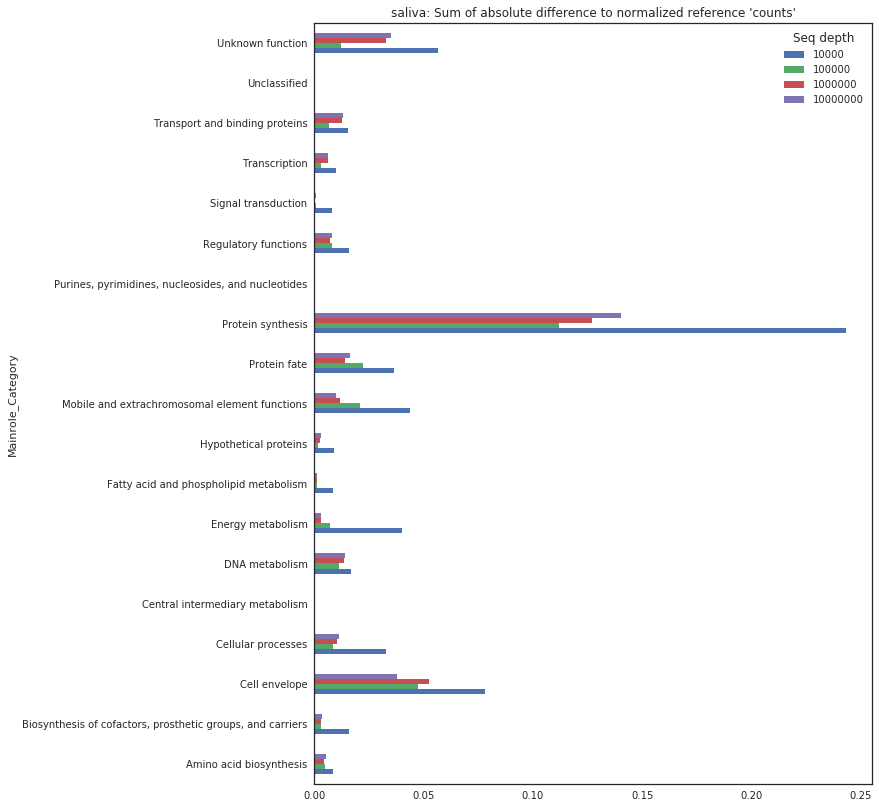

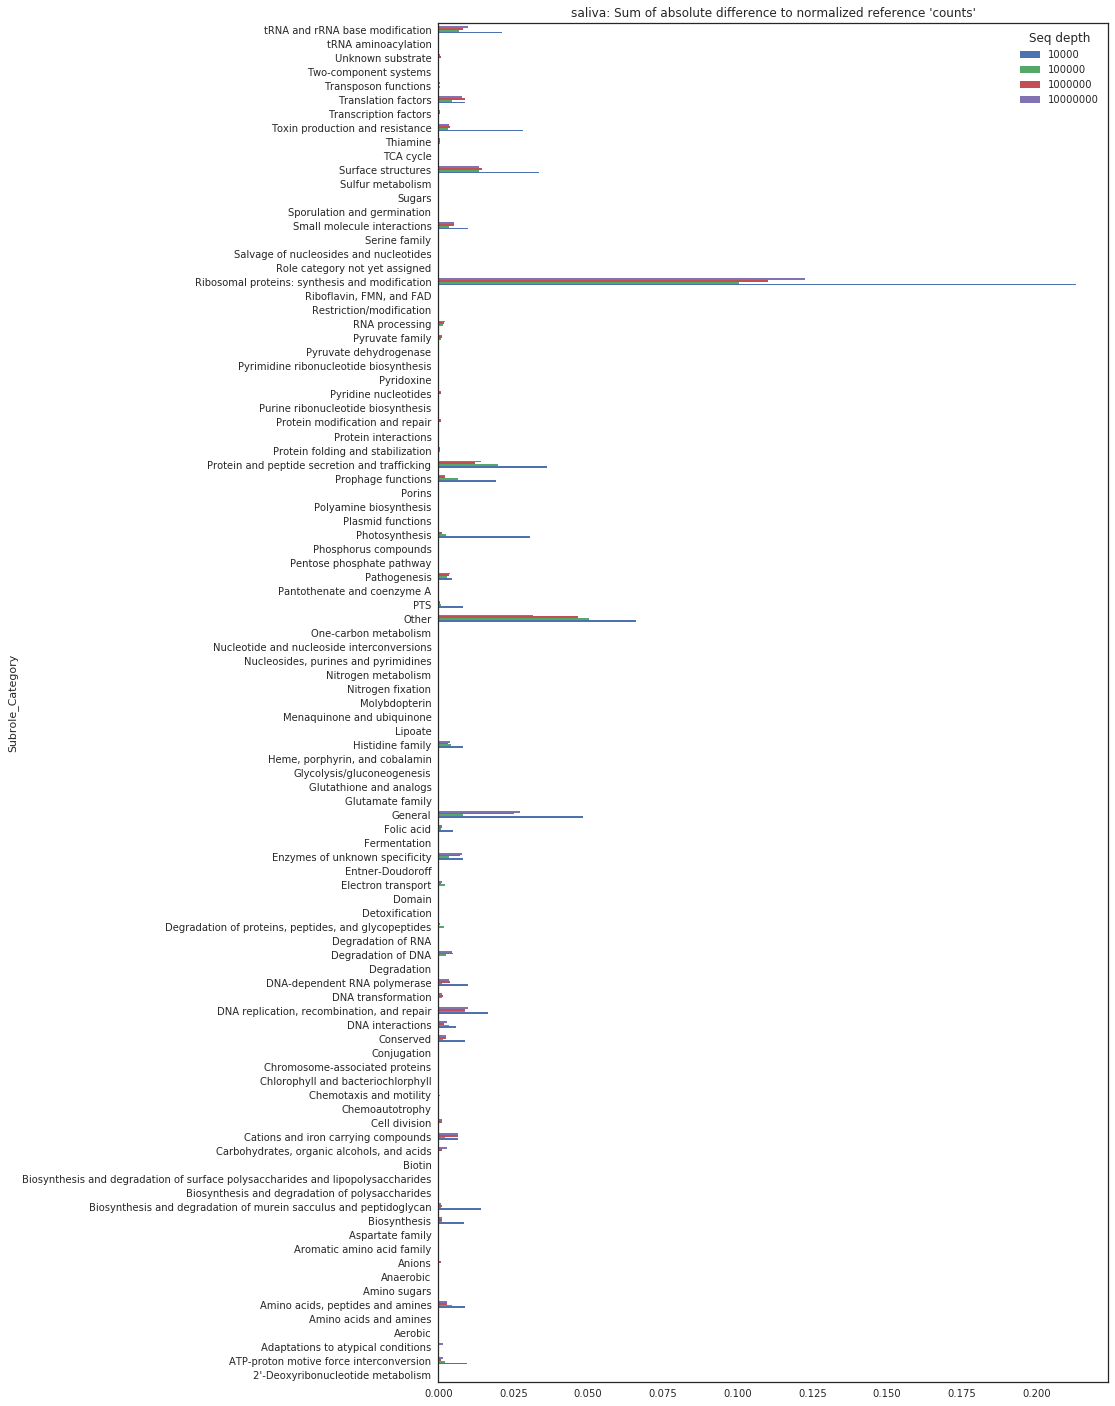

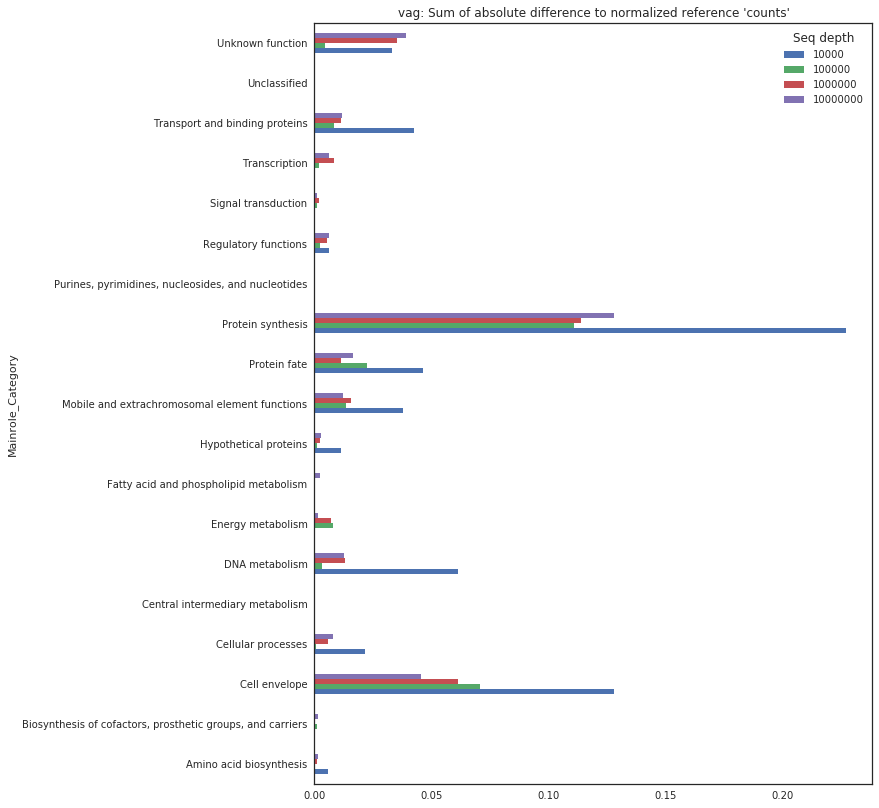

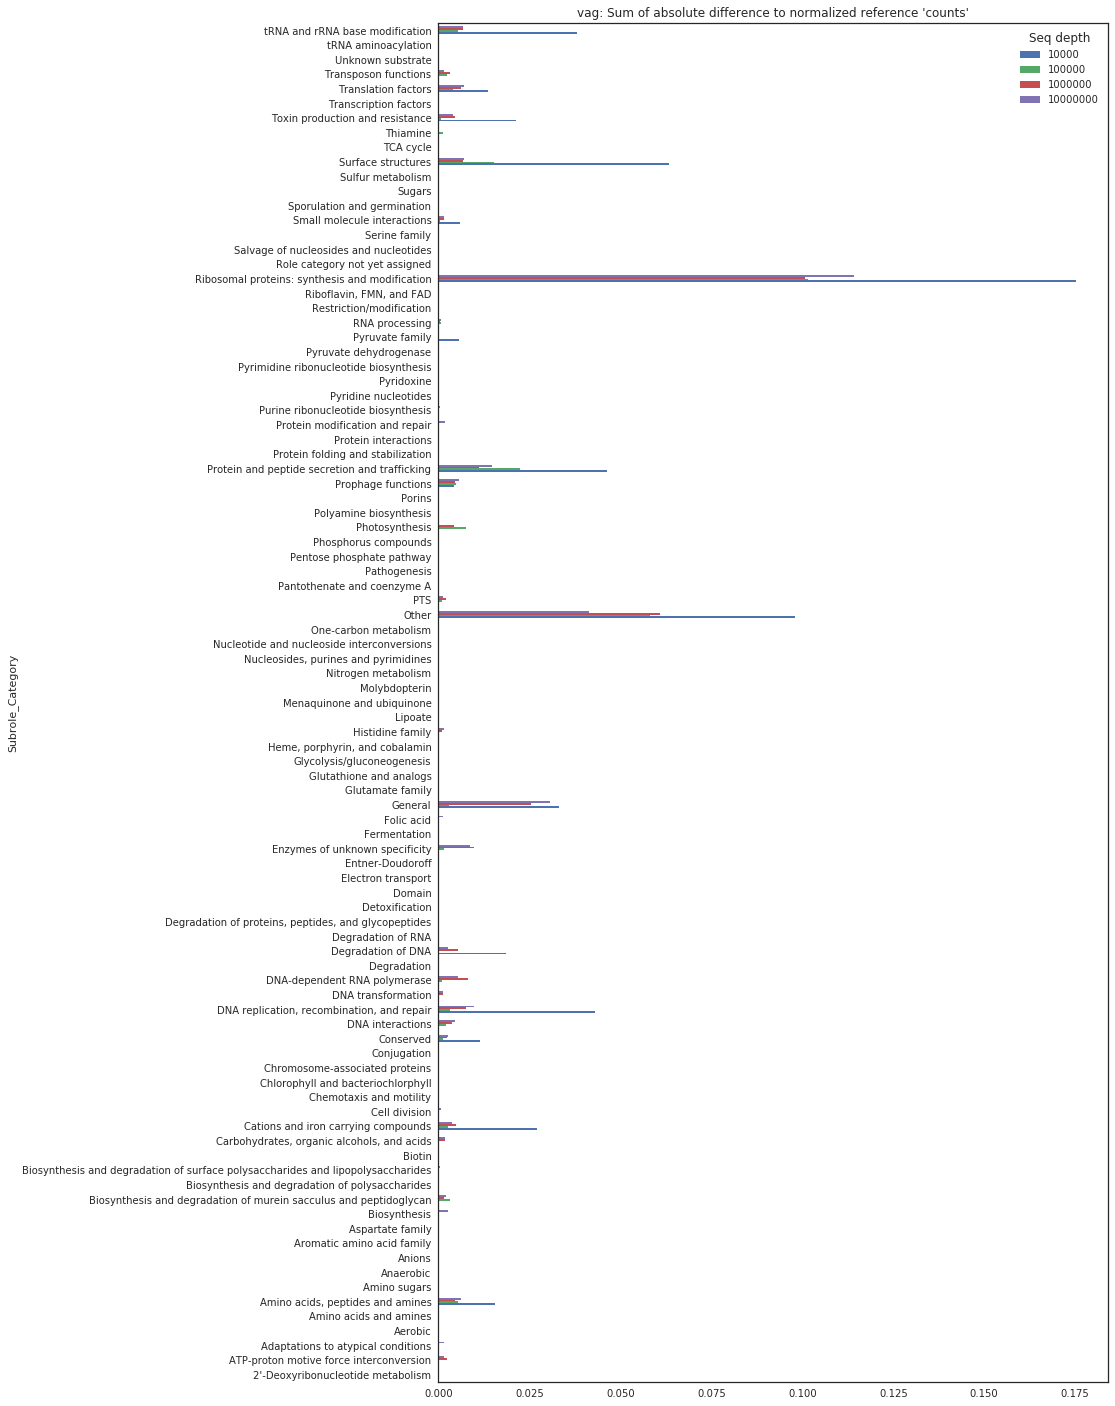

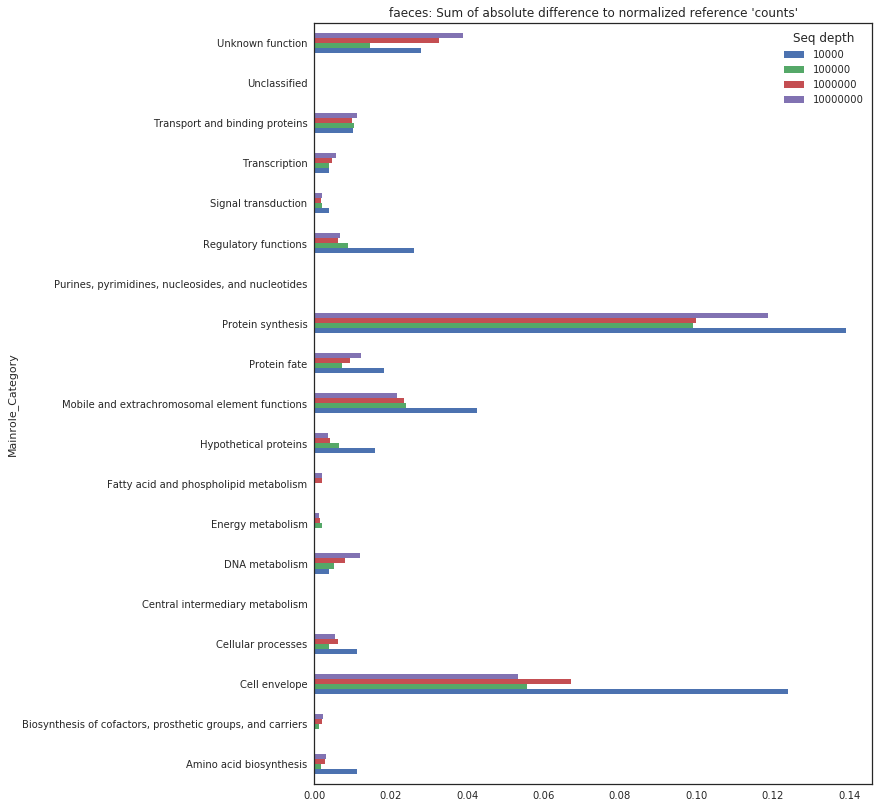

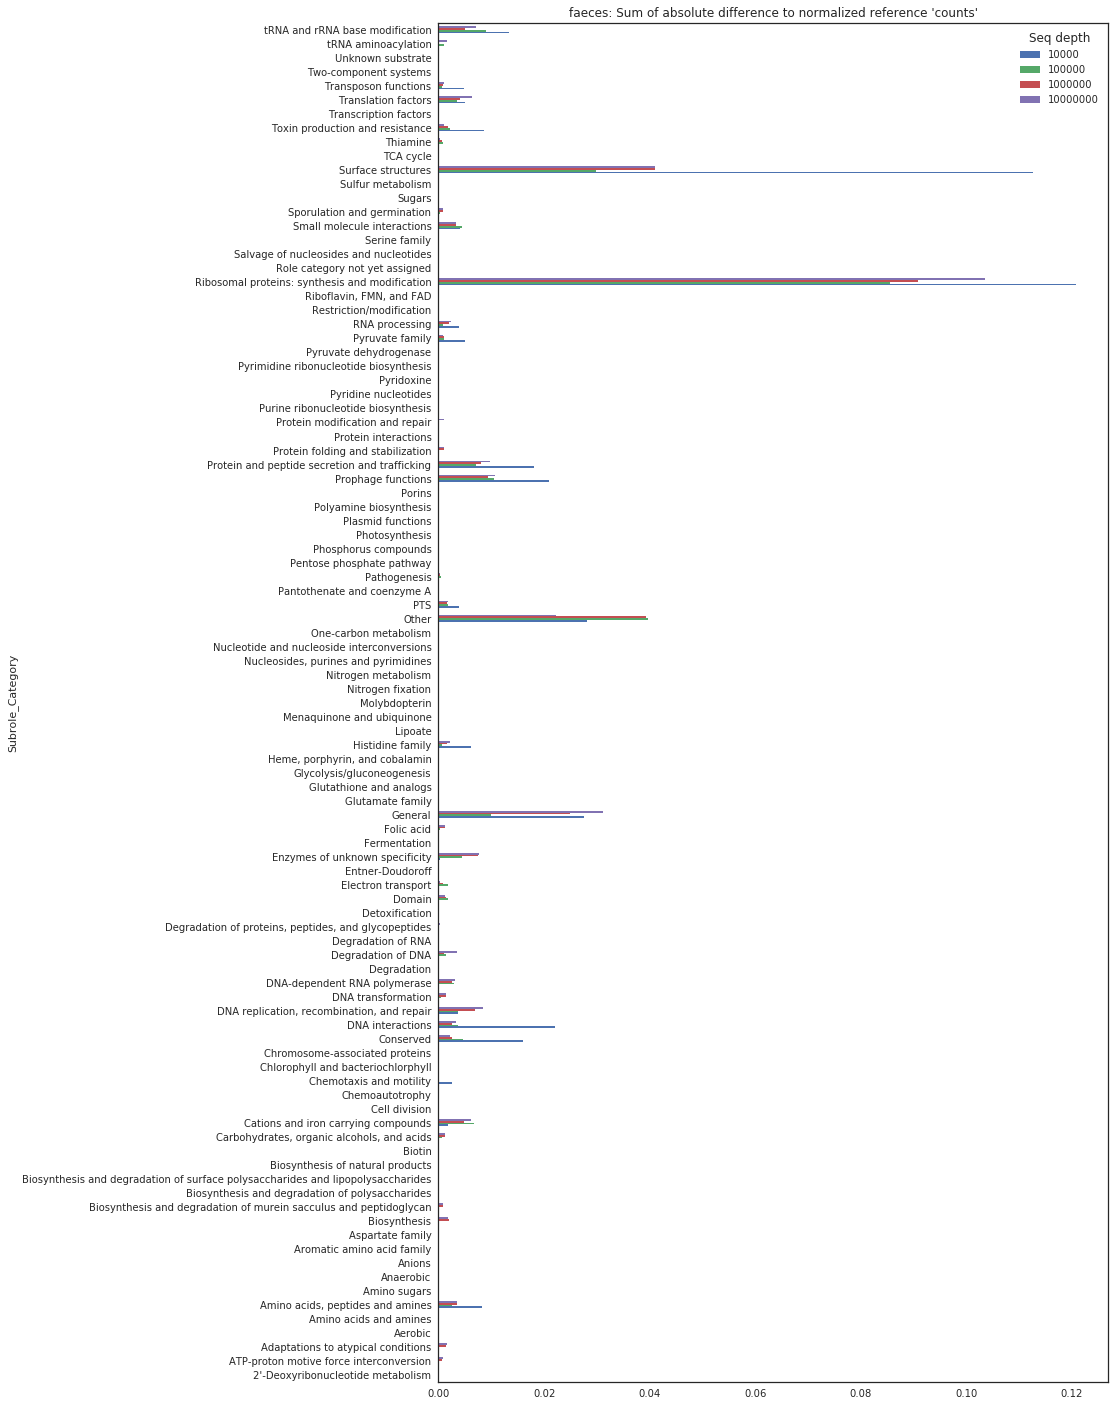

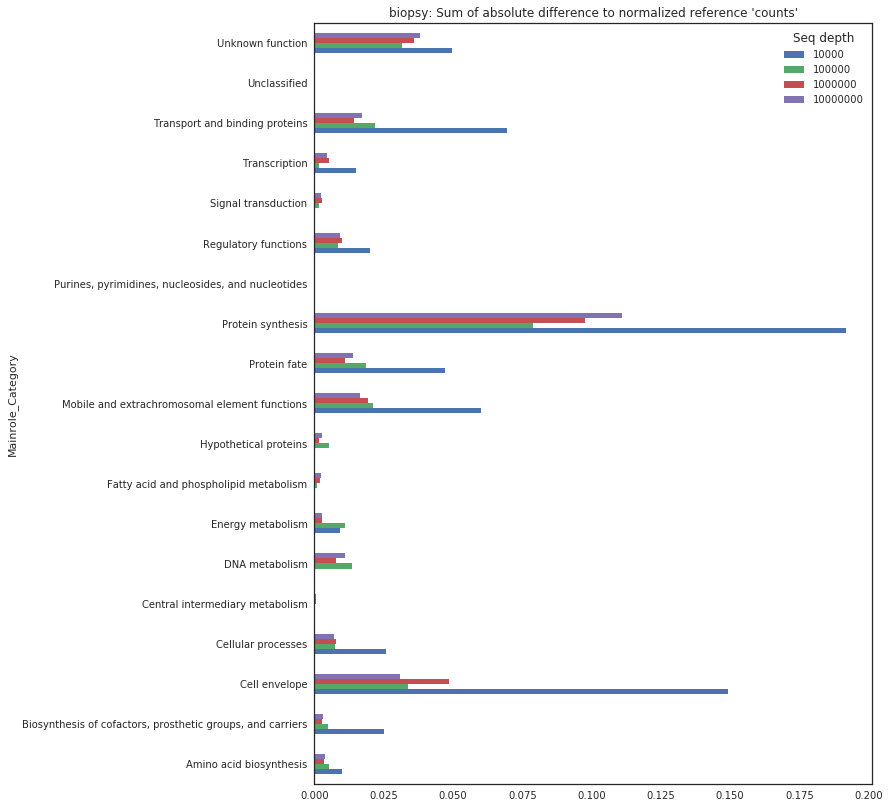

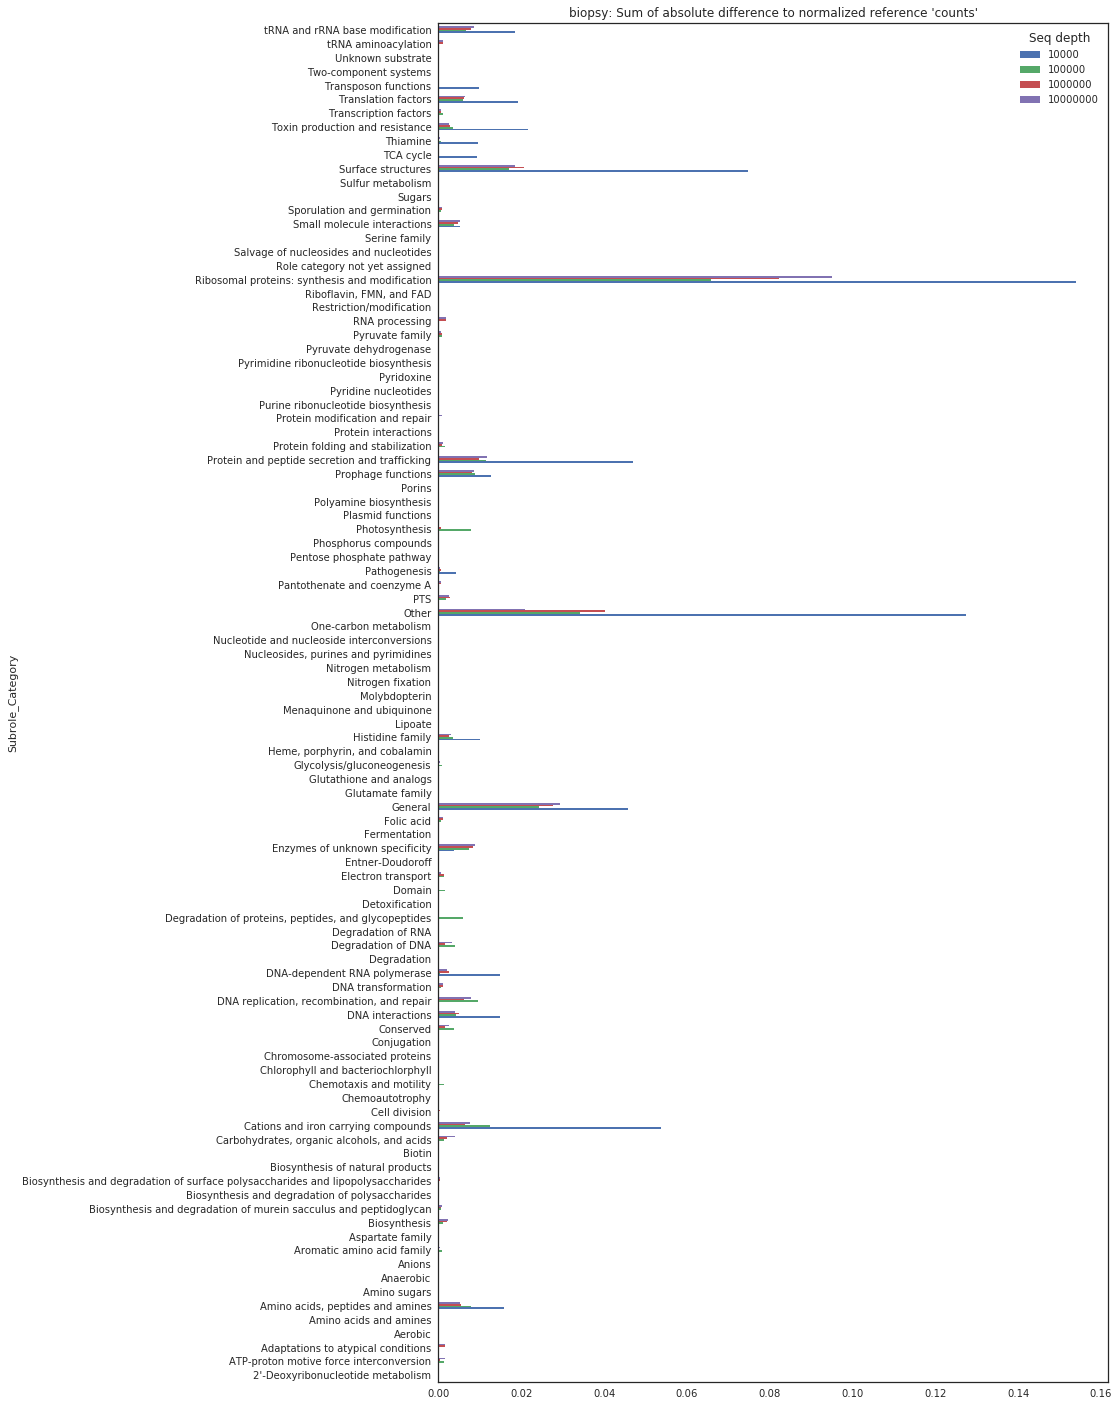

In [9]:
for sample_type in dfs_normalized.keys():
    ref_contig = "_m1_f500"
    if sample_type == "vag":
        ref_contig = ref_contig+"+yeast"
        
    # Get difference between normalized read counts and normalized reference 
    df = np.absolute(dfs_normalized[sample_type].sub(contigs_normalized[sample_type][sample_type+ref_contig], axis=0))

    # Create a multiindex over columns, to enable convenient grouping by read level
    col_index = pd.MultiIndex.from_tuples([tuple([a[0], a[1].strip("reads"), a[2].strip("rep")]) for a in df.columns.str.split("_")], names=["Sample_type", "Seq depth", "Replicate"])
    df.columns = col_index

    # Plot differences at Mainrole level
    mainrole_diffs = df\
        .groupby(level="Seq depth", axis=1).median()\
        .groupby("Mainrole_Category").sum()

    sum_stdev = pd.concat([mainrole_diffs.sum(), mainrole_diffs.std()], axis=1)
    sum_stdev.columns = ["Sum of differences", "Standard deviation"]
    print(sample_type)
    print(sum_stdev)

    ax1 = mainrole_diffs.plot(kind='barh', 
              figsize=(10,14), 
              title=sample_type+": Sum of absolute difference to normalized reference 'counts'")

    subrole_diffs = df\
        .groupby(level="Seq depth", axis=1).median()\
        .groupby("Subrole_Category").sum()

    ax2 = subrole_diffs.plot(kind='barh', 
              figsize=(12,25), 
              title=sample_type+": Sum of absolute difference to normalized reference 'counts'")

    f1 = ax1.get_figure()
    f2 = ax2.get_figure()
    
    f1.savefig(outdir+"/"+sample_type+"_Mainrole_diffs.png", bbox_inches='tight')
    f1.savefig(outdir+"/"+sample_type+"_Mainrole_diffs.pdf", bbox_inches='tight')
    f2.savefig(outdir+"/"+sample_type+"_Subrole_diffs.png", bbox_inches='tight')
    f2.savefig(outdir+"/"+sample_type+"_Subrole_diffs.pdf", bbox_inches='tight')

/home/ctmr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


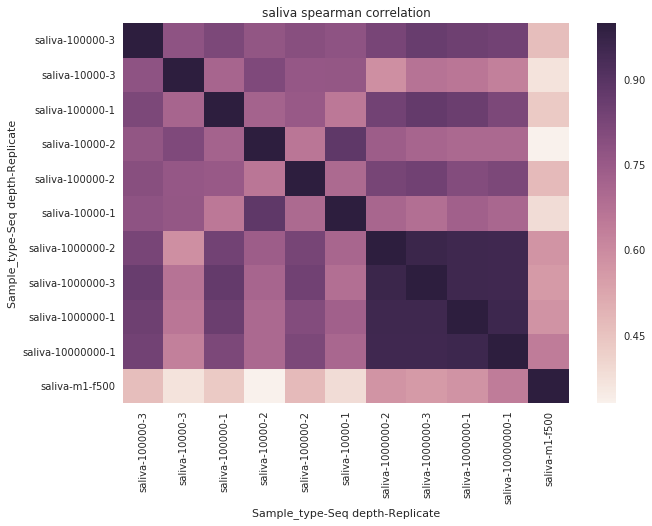

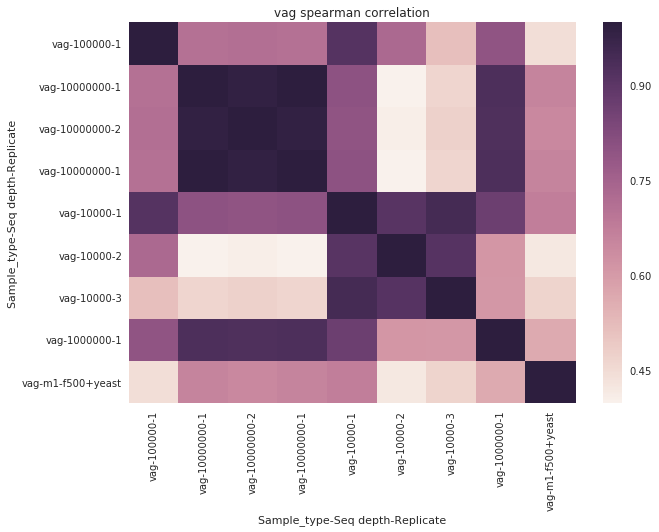

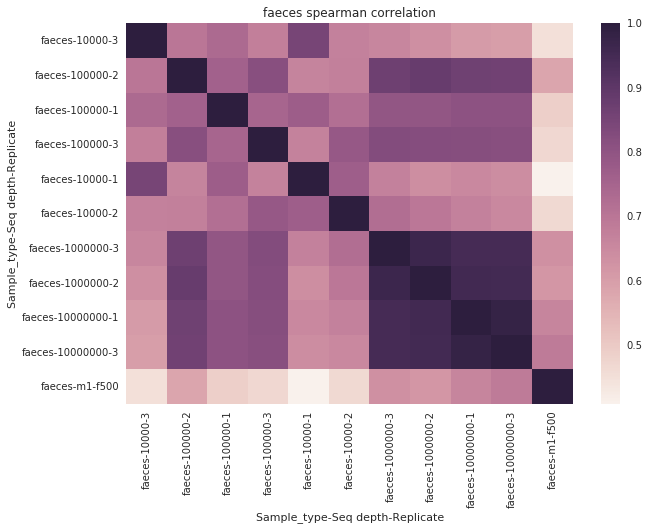

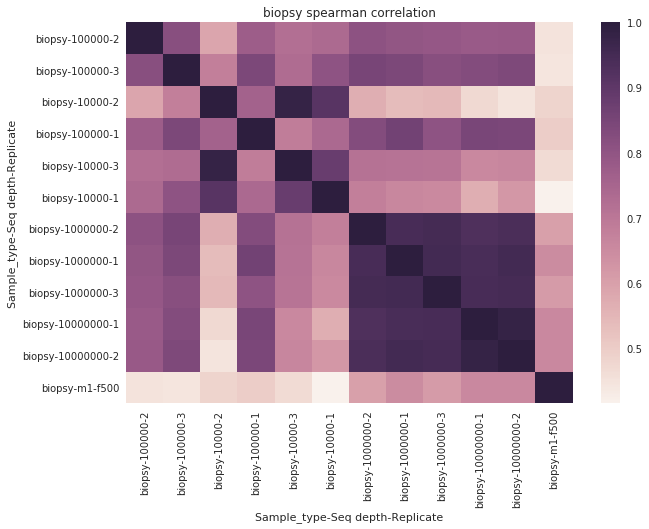

In [10]:
# Correlations
for sample_type in dfs_normalized.keys():
    ref_contig = "_m1_f500"
    if sample_type == "vag":
        ref_contig = ref_contig+"+yeast"
    df = dfs_normalized[sample_type].join(contigs_normalized[sample_type]["{stype}{contigs}".format(stype=sample_type, contigs=ref_contig)])
    
    fig, ax = plt.subplots(figsize=(10,7))
    plot_correlation(df, ax, sample_type, "spearman")
    
    basename = "{}_{}".format(sample_type, "correlations")
    fig.savefig(outdir+"/"+basename+".png", bbox_inches='tight')
    fig.savefig(outdir+"/"+basename+".pdf", bbox_inches='tight')

/home/ctmr/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/home/ctmr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


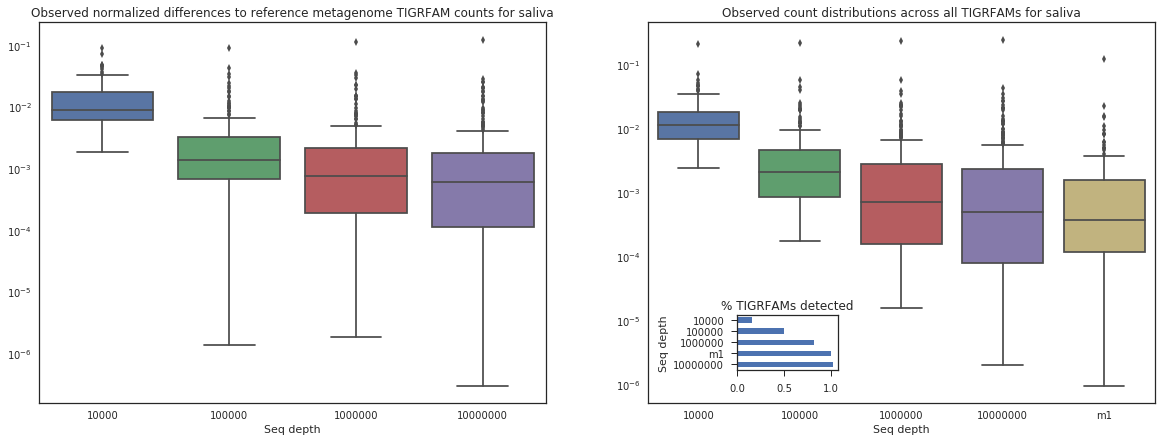

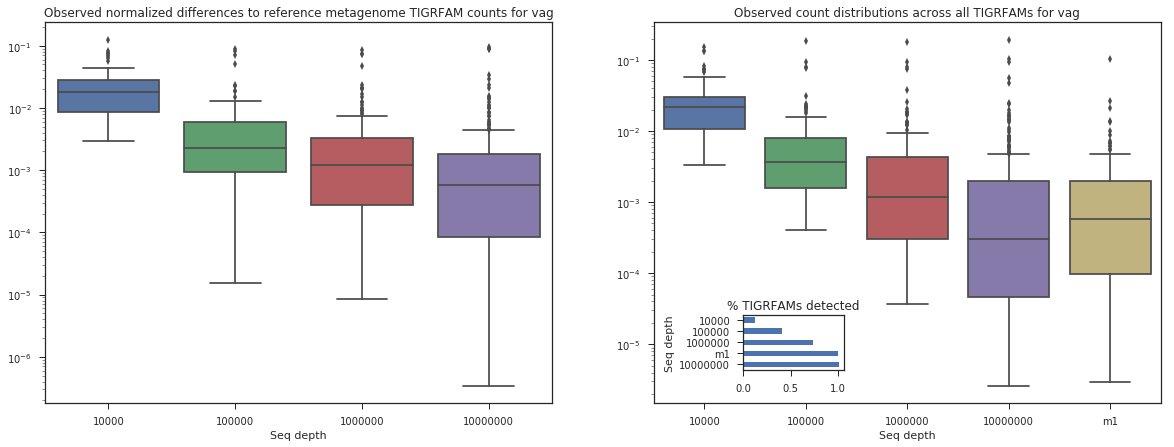

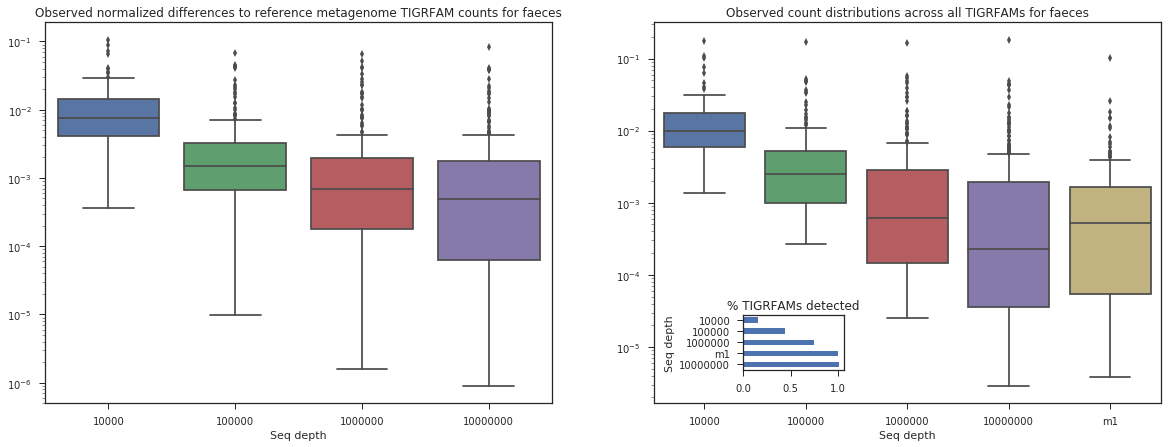

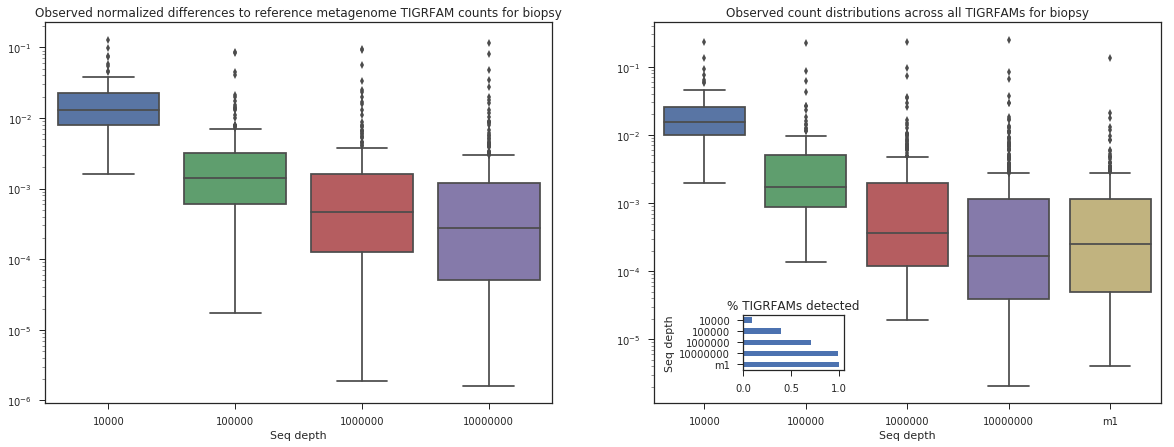

In [11]:
for sample_type in dfs_normalized.keys():
    ref_contig = "_m1_f500"
    ref_level = "f500"
    if sample_type == "vag":
        ref_contig = ref_contig+"+yeast"
        ref_level = ref_level+"+yeast"
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
    
    normalized_diffs = np.absolute(dfs_normalized[sample_type].sub(contigs_normalized[sample_type]["{stype}{contigs}".format(stype=sample_type, contigs=ref_contig)], axis=0))
    ax1 = plot_boxes(normalized_diffs, ax1, sample_type)
    ax1.set_title("Observed normalized differences to reference metagenome TIGRFAM counts for {}".format(sample_type))
    
    normalized_counts = dfs_normalized[sample_type].join(contigs_normalized[sample_type]["{stype}{contigs}".format(stype=sample_type, contigs=ref_contig)])
    ax2 = plot_boxes(normalized_counts, ax2, sample_type)
    ax2.set_title("Observed count distributions across all TIGRFAMs for {}".format(sample_type))
    
    # Compute proportion of truly present TIGRFAMs detected
    ax3 = fig.add_axes([0.61, 0.19, 0.07, 0.11])
    nulls = normalized_counts.notnull()
    detection_coverage = nulls.sum() / nulls.sum()[(sample_type, "m1", ref_level)]
    detection_coverage.groupby("Seq depth").mean().sort_values(ascending=False).plot(kind='barh', ax=ax3)
    ax3.set_title("% TIGRFAMs detected")
    
    basename = "{}_{}".format(sample_type, "boxplots")
    fig.savefig(outdir+"/"+basename+".png", bbox_inches='tight')
    fig.savefig(outdir+"/"+basename+".pdf", bbox_inches='tight')

# Plots!
Here are lots of different plots. It's all tests of different ways of looking at the data. When we decide on some representative/good ways of presenting the data, we will create a function that produces all those plots for a specific sample type.

/home/ctmr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


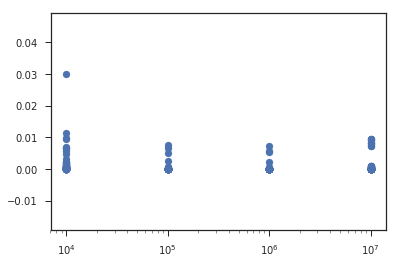

In [156]:
# Get difference between normalized read counts and normalized reference 
df = dfs_normalized["vag"].sub(contigs_normalized["vag"]["vag_m1_f500+yeast"], axis=0)

# Create a multiindex over columns, to enable convenient grouping by read level
col_index = pd.MultiIndex.from_tuples([tuple([a[0], a[1].strip("reads"), a[2].strip("rep")]) for a in df.columns.str.split("_")], names=["Sample_type", "Seq depth", "Replicate"])
df.columns = col_index

df2 = df**2
fig, ax = plt.subplots()
molten = df2.melt().dropna()
ax.scatter(x=pd.to_numeric(molten["Seq depth"]), y=molten["value"])
ax.set_xscale('log')

#sns.lmplot(x="Seq depth", y="value", data=molten, logistic=True)

                         Sum of differences  Standard deviation
zzz_10000000reads_test3            0.689887            0.035789


/home/ctmr/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


(zzz, 10000000, test3)    0
vag_m1_f500+yeast         8
dtype: int64

/home/ctmr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


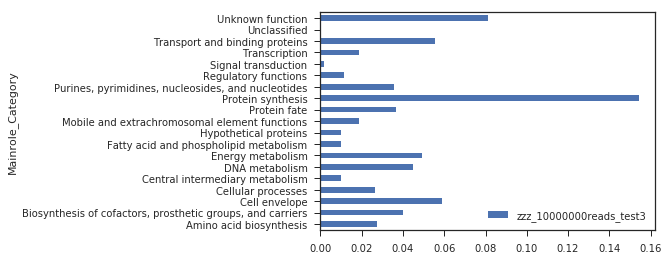

In [351]:
df = load_TIGRFAM_counts(counts_filename="/home/ctmr/projects/labcore/seq_depth/simulated_metagenomes/zzz_test3.tigrfam_annotation_counts.tsv")
df.columns = ["zzz_10000000reads_test3"]
df = join_TIGRFAM_annotations(df, tigrfam_annotations_length)
df = normalize_by_read_count(df)
df = normalize_by_hmm_length(df)

# Normalized differences to reference contigs
diff = np.absolute(df.sub(contigs_normalized["vag"]["vag_m1_f500+yeast"], axis=0))
# Create a multiindex over columns, to enable convenient grouping by read level
col_index = pd.MultiIndex.from_tuples([tuple([a[0], a[1].strip("reads"), a[2].strip("rep")]) for a in df.columns.str.split("_")], names=["Sample_type", "Seq depth", "Replicate"])
df.columns = col_index
# Compute differences at Mainrole level
mainrole_diffs = diff.groupby("Mainrole_Category").sum()
sum_stdev = pd.concat([mainrole_diffs.sum(), mainrole_diffs.std()], axis=1)
sum_stdev.columns = ["Sum of differences", "Standard deviation"]
print(sum_stdev)
mainrole_diffs.plot(kind='barh')

df.join(contigs_normalized["vag"]["vag_m1_f500+yeast"]).isnull().sum()